In [ ]:
!pip install emoji
!pip install fasttext
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install flask

In [17]:
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Flask import Flask, request, jsonify
import io

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
vocab_size = 2957
embedding_dim = 300
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 800
num_epochs = 15

In [19]:
sentences = []
labels = []

# Load the dataset
url = "https://raw.githubusercontent.com/RusiruWijethilake/DepFlow/main/new_dataset.csv"
df = pd.read_csv(url)

labels = df['class']

for sent in df['text']:
  sentences.append(sent)

In [20]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print(len(word_index))

print(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

3686
{'<OOV>': 1, 'මට': 2, 'මම': 3, 'කරන්න': 4, 'නෑ': 5, 'වෙලා': 6, 'එපා': 7, 'කියලා': 8, 'මන්': 9, 'මේ': 10, 'ගොඩක්': 11, 'මගේ': 12, 'එක': 13, 'ඒ': 14, 'කෙනෙක්': 15, 'මං': 16, 'දැන්': 17, 'වගේ': 18, 'නිසා': 19, 'ගන්න': 20, 'හිතෙනවා': 21, 'ඉන්න': 22, 'හරි': 23, 'වෙන්න': 24, 'ගැන': 25, 'දේවල්': 26, 'එක්ක': 27, 'යන්න': 28, 'හිත': 29, 'ඉන්නේ': 30, 'කරන': 31, 'ලොකු': 32, 'ඒත්': 33, 'නැ': 34, 'ජීවිතේ': 35, 'එයා': 36, 'නම්': 37, 'ආදරේ': 38, 'නැති': 39, 'බැරි': 40, 'දෙයක්': 41, 'මානසික': 42, 'ඒක': 43, 'තියෙන්නේ': 44, 'කතා': 45, 'බෑ': 46, 'වෙනවා': 47, 'මාව': 48, 'කියල': 49, 'එහෙම': 50, 'කියන්න': 51, 'උනා': 52, 'කිසිම': 53, 'වෙන': 54, 'ඕන': 55, 'නැහැ': 56, 'පුලුවන්': 57, 'හැම': 58, 'කොහොමද': 59, 'මේක': 60, 'වැඩ': 61, 'දේ': 62, 'ගොඩාක්': 63, 'තියෙනවා': 64, 'ඇයි': 65, 'මොකද': 66, 'ගෙදර': 67, 'ඇත්තටම': 68, 'උදව්': 69, 'ඉන්නෙ': 70, 'පාඩම්': 71, 'දෙන්න': 72, 'ඔබ': 73, 'අනේ': 74, 'මිනිස්සු': 75, 'කියන': 76, 'නිතරම': 77, 'ඇති': 78, 'එකක්': 79, 'කැමති': 80, 'කරලා': 81, 'වලට': 82, 'යනවා': 83, 'බය': 84, 

In [22]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [23]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz

!gzip -d cc.si.300.bin.gz

--2023-04-20 09:40:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.83, 108.157.162.35, 108.157.162.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si.300.bin.gz’

cc.si.300.bin.gz    100%[===================>]   2.96G  96.1MB/s    in 33s     

2023-04-20 09:40:55 (91.9 MB/s) - ‘cc.si.300.bin.gz’ saved [3181346570/3181346570]

gzip: cc.si.300.bin already exists; do you wish to overwrite (y or n)? y


In [24]:
import fasttext
import fasttext.util

ft = fasttext.load_model("cc.si.300.bin")
ft.get_dimension()

# Mapping FastText word vectors with word in the dataset 
embedding_dim = ft.get_dimension()
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           1106100   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,325,877
Trainable params: 219,777
Non-trainable params: 1,106,100
_________________________________________________________________


In [26]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/15
25/25 - 8s - loss: 0.6649 - accuracy: 0.6150 - val_loss: 0.5976 - val_accuracy: 0.7171 - 8s/epoch - 329ms/step
Epoch 2/15
25/25 - 1s - loss: 0.5679 - accuracy: 0.6963 - val_loss: 0.5770 - val_accuracy: 0.7171 - 1s/epoch - 44ms/step
Epoch 3/15
25/25 - 1s - loss: 0.5069 - accuracy: 0.7450 - val_loss: 0.5327 - val_accuracy: 0.7268 - 1s/epoch - 45ms/step
Epoch 4/15
25/25 - 1s - loss: 0.4607 - accuracy: 0.7750 - val_loss: 0.5531 - val_accuracy: 0.7073 - 1s/epoch - 43ms/step
Epoch 5/15
25/25 - 2s - loss: 0.4351 - accuracy: 0.7900 - val_loss: 0.9022 - val_accuracy: 0.7268 - 2s/epoch - 75ms/step
Epoch 6/15
25/25 - 2s - loss: 0.4405 - accuracy: 0.7925 - val_loss: 0.8075 - val_accuracy: 0.7268 - 2s/epoch - 61ms/step
Epoch 7/15
25/25 - 1s - loss: 0.3989 - accuracy: 0.8200 - val_loss: 0.6786 - val_accuracy: 0.7268 - 1s/epoch - 44ms/step
Epoch 8/15
25/25 - 1s - loss: 0.3617 - accuracy: 0.8375 - val_loss: 0.7212 - val_accuracy: 0.7220 - 1s/epoch - 43ms/step
Epoch 9/15
25/25 - 1s - loss: 0

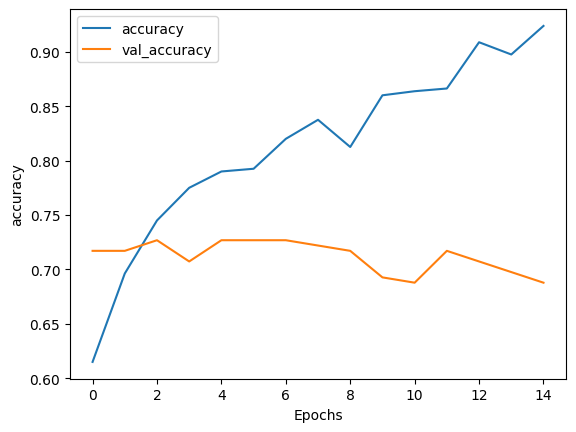

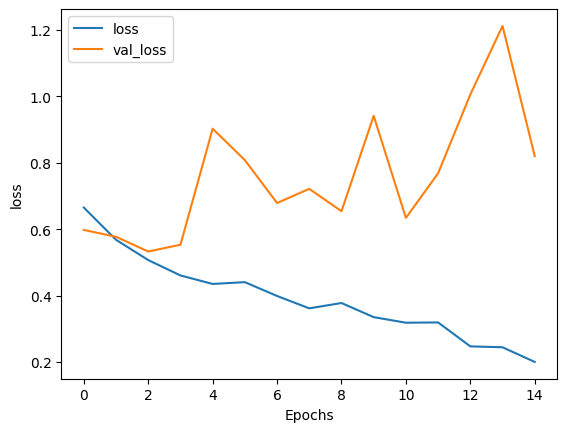

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
# Model Evaluation
eval_sequences = tokenizer.texts_to_sequences(testing_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(eval_padded)
predicted_labels = []
for x in pred:
  predicted_labels.append(int(x.round().item()))

predicted_labels = tf.convert_to_tensor(predicted_labels)
print(classification_report(testing_labels, predicted_labels))

7/7 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       148
           1       0.40      0.25      0.30        57

    accuracy                           0.69       205
   macro avg       0.57      0.55      0.55       205
weighted avg       0.65      0.69      0.66       205



In [29]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

නැති බැරි කම් අග හිග කම් මැද ජීවත් වෙනවට වඩා හොදයි මියදුනා නම් දෙයියනේ ? ? ? ? ? ?
හැමදේම අත හැර ගියා නම් හරි වගේ 
1


In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(3687, 300)


In [31]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [34]:
!mkdir -p saved_model
model.save('depflow_trained_model.h5')

In [35]:
sentence = ["මට ඇති මේ දුක දරන් හිටියා.", "මට සතුටුයි හොදටම"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 31ms/step
[[0.9385042 ]
 [0.67147434]]


In [36]:
def check_depressive(post: str):
  sentence = [post]
  sequences = tokenizer.texts_to_sequences(sentence)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  post_prediction = model.predict(padded)
  label = post_prediction.round().item()
  if label == 1 :
    print(post, " : is a depressive post - ", post_prediction)
  else:
    print(post, " : is not a depressive post - ", post_prediction)

check_depressive("මට ඇති මේ දුක දරන් හිටියා.")
check_depressive("මම මැරිලම යන්නම්")
check_depressive("මම මරිලා ගියාම හැමොටම හොදයි.")
check_depressive("දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි")
check_depressive("අපි හෙට උදේට මොනවද කන්නේ?")
check_depressive('ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ')
check_depressive('ඔයාටනම් ඉතින් හිනා')
check_depressive('මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී')
check_depressive('මට හොදටම depression')
check_depressive('I feel like I want to cry')
check_depressive('මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා')

1/1 [==============================] - 0s 38ms/step
මට ඇති මේ දුක දරන් හිටියා.  : is a depressive post -  [[0.9385042]]
1/1 [==============================] - 0s 43ms/step
මම මැරිලම යන්නම්  : is not a depressive post -  [[0.15672046]]
1/1 [==============================] - 0s 38ms/step
මම මරිලා ගියාම හැමොටම හොදයි.  : is a depressive post -  [[0.7080585]]
1/1 [==============================] - 0s 55ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි  : is not a depressive post -  [[0.06130857]]
1/1 [==============================] - 0s 41ms/step
අපි හෙට උදේට මොනවද කන්නේ?  : is not a depressive post -  [[0.01352377]]
1/1 [==============================] - 0s 41ms/step
ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ  : is a depressive post -  [[0.97362405]]
1/1 [==============================] - 0s 39ms/step
ඔයාටනම් ඉතින් හිනා  : is not a depressive post -  [[0.05381739]]
1/1 [==============================] - 0s 42ms/step
මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී  : is a depressive post -  [[0.88504785]]
1/1 [=========

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
